# Stacking
How often do top players at one position team with players at another position (#1 QB and #1 WR in same offense, etc)?

#### __Goal__: Determine if season-long fantasy performance of certain positions is affected by the performance of other positions.

This analysis will specifically look at __PPR__ scoring.

The data only contains full-season data (not game-by-game), so it is tailored towards __redraft__ fantasy football leagues. It may not be as predictive for best ball leagues.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# display
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# global random_state
random_state = 9

In [2]:
# load data
df = pd.read_csv('../data/final_data/master.csv')

# view
print(f'The data has {df.shape[0]} rows and {df.shape[1]} columns:')
df.head()

The data has 28740 rows and 116 columns:


,Player,Tm,Pos,Age,G,GS,Pass_Cmp,Pass_Att,Pass_Yds,Pass_TD,Pass_Int,Rush_Att,Rush_Yds,Rush_Y/A,Rush_TD,Rec_Tgt,Rec_Rec,Rec_Yds,Rec_Y/R,Rec_TD,Fmb,FmbLost,Key,Year,Scrim_Yds,Scrim_TD,num_games,games_played_pct,games_started_pct,ProBowl,AllPro,Exp,New_Team,Will_be_on_New_Team,Traded,Pass_Y/A,Touches,Cmp%,Catch%,Pass_Cmp_per_game,Pass_Att_per_game,Pass_Yds_per_game,Pass_TD_per_game,Pass_Int_per_game,Rush_Att_per_game,Rush_Yds_per_game,Rush_TD_per_game,Rec_Tgt_per_game,Rec_Rec_per_game,Rec_Yds_per_game,...,PPT_ppr,PPT_6,SeasonOvrRank_standard,SeasonOvrRank_half-ppr,SeasonOvrRank_ppr,SeasonOvrRank_6,SeasonPosRank_standard,SeasonPosRank_half-ppr,SeasonPosRank_ppr,SeasonPosRank_6,PPGOvrRank_standard,PPGOvrRank_half-ppr,PPGOvrRank_ppr,PPGOvrRank_6,PPGPosRank_standard,PPGPosRank_half-ppr,PPGPosRank_ppr,PPGPosRank_6,PPTOvrRank_standard,PPTOvrRank_half-ppr,PPTOvrRank_ppr,PPTOvrRank_6,PPTPosRank_standard,PPTPosRank_half-ppr,PPTPosRank_ppr,PPTPosRank_6,VORP_standard_10tm,VORP_half-ppr_10tm,VORP_ppr_10tm,VORP_6_10tm,VORP_standard_12tm,VORP_half-ppr_12tm,VORP_ppr_12tm,VORP_6_12tm,VORP_standard_10tm_3WR,VORP_half-ppr_10tm_3WR,VORP_ppr_10tm_3WR,VORP_6_10tm_3WR,VORP_standard_12tm_3WR,VORP_half-ppr_12tm_3WR,VORP_ppr_12tm_3WR,VORP_6_12tm_3WR,SeasonTarget_standard,SeasonTarget_half-ppr,SeasonTarget_ppr,SeasonTarget_6,PPGTarget_standard,PPGTarget_half-ppr,PPGTarget_ppr,PPGTarget_6
0,Ron Johnson,NYG,RB,23,14,14,0,0,0,0,0,263,1027,3.904943,8,91.185521,48,487,10.145833,4,5.0,2.75,JohnRo02,1970,1514,12,16,0.875,1.000000,True,True,1,False,False,False,0.000000,311,0.000000,0.526399,0.00,0.00,0.0,0.0,0.00,18.785714,73.357143,0.571429,6.513251,3.428571,34.785714,...,0.854984,0.854984,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,155.0,163.0,164.0,165.0,24.0,29.0,31.0,31.0,120.80,132.40,144.90,144.90,131.50,146.50,161.50,161.50,120.80,132.40,144.90,144.90,131.50,146.50,161.50,161.50,24.1,27.1,30.1,30.1,12.050000,13.550000,15.050000,15.050000
1,Mike Donohoe,ATL,TE,25,14,0,0,0,0,0,0,0,0,0.000000,0,3.799397,2,36,18.000000,1,0.0,0.00,DonoMi00,1970,36,1,16,0.875,0.000000,False,False,3,False,False,False,0.000000,2,0.000000,0.526399,0.00,0.00,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.271385,0.142857,2.571429,...,5.800000,5.800000,254.0,260.0,260.0,262.0,42.0,44.0,44.0,44.0,276.0,281.0,283.0,285.0,45.0,46.0,47.0,47.0,7.0,7.0,6.0,6.0,4.0,4.0,4.0,4.0,-57.60,-74.60,-91.60,-91.60,-50.80,-67.40,-84.40,-84.40,-57.60,-74.60,-91.60,-91.60,-50.80,-67.40,-84.40,-84.40,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,Mike Ditka,DAL,TE,31,14,0,0,0,0,0,0,0,0,0.000000,0,15.197587,8,98,12.250000,0,0.0,0.00,DitkMi00,1970,98,0,16,0.875,0.000000,False,False,9,False,False,False,0.000000,8,0.000000,0.526399,0.00,0.00,0.0,0.0,0.00,0.000000,0.000000,0.000000,1.085542,0.571429,7.000000,...,2.225000,2.225000,251.0,243.0,237.0,240.0,41.0,40.0,39.0,39.0,275.0,271.0,267.0,270.0,44.0,42.0,41.0,41.0,114.0,111.0,110.0,110.0,44.0,44.0,44.0,44.0,-57.40,-71.40,-85.40,-85.40,-50.60,-64.20,-78.20,-78.20,-57.40,-71.40,-85.40,-85.40,-50.60,-64.20,-78.20,-78.20,42.2,57.2,72.2,72.2,3.014286,4.085714,5.157143,5.157143
3,Rich Coady,CHI,TE,26,14,8,0,0,0,0,0,0,0,0.000000,0,11.398190,6,44,7.333333,1,0.0,0.00,CoadRi20,1970,44,1,16,0.875,0.571429,False,False,4,False,False,False,0.000000,6,0.000000,0.526399,0.00,0.00,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.814156,0.428571,3.142857,...,2.733333,2.733333,248.0,247.0,244.0,246.0,40.0,41.0,41.0,41.0,271.0,272.0,274.0,276.0,42.0,43.0,43.0,43.0,84.0,83.0,83.0,83.0,33.0,32.0,32.0,32.0,-56.80,-71.80,-86.80,-86.80,-50.00,-64.60,-79.60,-79.60,-56.80,-71.80,-86.80,-86.80,-50.00,-64.60,-79.60,-79.60,-1.1,-1.1,-1.1,-1.1,-0.078571,-0.078571,-0.078571,-0.078571
4,Pete Beathard,STL,QB,28,4,0,7,17,114,2,1,2,2,1.000000,0,0.000000,0,0,0.000000,0,1.0,0.55,BeatPe00,1970,2,0,16,0.250,0.000000,False,False,6,False,False,False,6.705882,19,0.411765,0.000000,1.75,4.25,28.5,0.5,0.25,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,...,0.508421,0.771579,253.0,

## Stacking
How often do top players at one position team with players at another position (#1 RB and #1 WR in same offense, etc)?

In [3]:
# team group we will be using
tm_groups = df.groupby(['Year', 'Tm'])

# initialize empty 'Tm_Pos' column
df['Tm_Pos'] = np.nan

# iterate through tm_groups
for name, group in tm_groups:
    
    # assign qb1 to QB with the most Pass_Att, set 'Tm_Pos'
    qb1 = group[group['Pos'] == 'QB'].sort_values('Pass_Att', ascending=False).iloc[0]
    df.loc[qb1.name, 'Tm_Pos'] = 'QB1'

    # assign rb1 and rb2 to RBs with the most 'Touches'
    rbs = group[group['Pos'] == 'RB'].sort_values('Touches', ascending=False)
    if len(rbs) > 0:
        rb1 = rbs.iloc[0]
        df.loc[rb1.name, 'Tm_Pos'] = 'RB1'
    if len(rbs) > 1:
        rb2 = rbs.iloc[1]
        df.loc[rb2.name, 'Tm_Pos'] = 'RB2'

    # assign wr1, wr2, and wr3 to WRs with the most 'Rec_Rec'
    wrs = group[group['Pos'] == 'WR'].sort_values('Rec_Rec', ascending=False)
    if len(wrs) > 0:
        wr1 = wrs.iloc[0]
        df.loc[wr1.name, 'Tm_Pos'] = 'WR1'
    if len(wrs) > 1:
        wr2 = wrs.iloc[1]
        df.loc[wr2.name, 'Tm_Pos'] = 'WR2'
    if len(wrs) > 2:
        wr3 = wrs.iloc[2]
        df.loc[wr3.name, 'Tm_Pos'] = 'WR3'

    # assign te1 to TE with the most 'Rec_Rec'
    tes = group[group['Pos'] == 'TE'].sort_values('Rec_Rec', ascending=False)
    if len(tes) > 0:
        te1 = tes.iloc[0]
        df.loc[te1.name, 'Tm_Pos'] = 'TE1'

# drop rows with NaN in 'Tm_Pos'
df = df.dropna(subset=['Tm_Pos'])

In [4]:
# Filter the data for QB1
qb1_data = df[df['Tm_Pos'] == 'QB1']

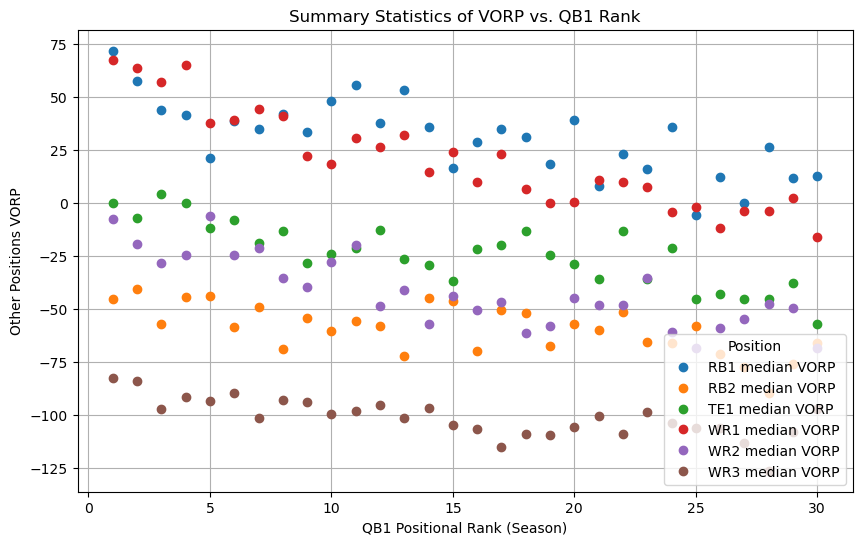

In [114]:
# Merge QB1 data back with the original dataframe on 'Year' and 'Tm' to get other positions
merged_df = df.merge(qb1_data[['Year', 'Tm', 'SeasonPosRank_ppr']], on=['Year', 'Tm'], suffixes=('', '_QB1'))

# Group by QB1 rank and position, then calculate summary statistics
summary_df = merged_df.groupby(['SeasonPosRank_ppr_QB1', 'Tm_Pos'])['VORP_ppr_10tm'].agg(
    ['mean', 'median']
).reset_index()

# drop rows where 'SeasonPosRank_ppr_QB1' is greater than 30 or 'Tm_Pos' is 'QB1'
summary_df = summary_df[(summary_df['SeasonPosRank_ppr_QB1'] <= 30) & (summary_df['Tm_Pos'] != 'QB1')]

# plot
plt.figure(figsize=(10, 6))
for pos in summary_df['Tm_Pos'].unique():
    pos_data = summary_df[summary_df['Tm_Pos'] == pos]
    plt.errorbar(pos_data['SeasonPosRank_ppr_QB1'], pos_data['median'], 
                 fmt='o', label=f'{pos} median VORP')
plt.title('Summary Statistics of VORP vs. QB1 Rank')
plt.xlabel('QB1 Positional Rank (Season)')
plt.ylabel('Other Positions VORP')
plt.legend(title='Position', loc='lower right')
plt.grid(True)
plt.show()

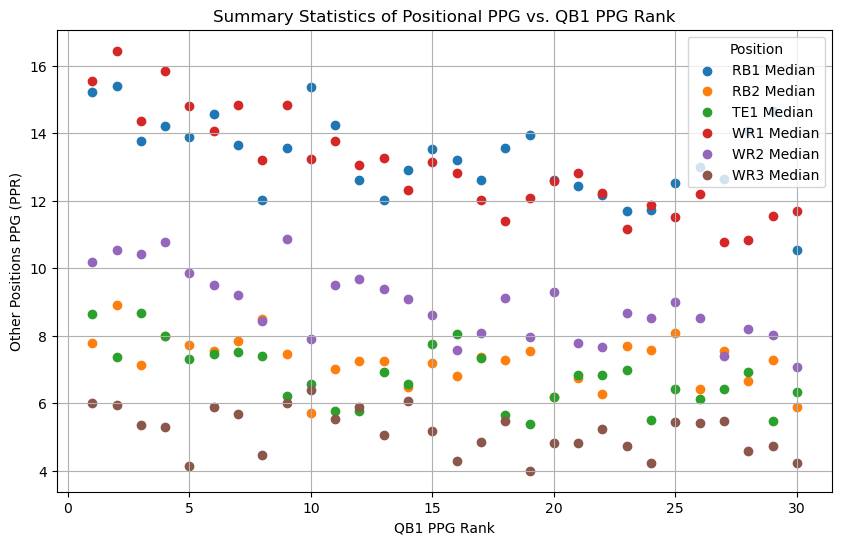

In [98]:
# Merge QB1 data back with the original dataframe on 'Year' and 'Tm' to get other positions
merged_ppg_df  = df.merge(qb1_data[['Year', 'Tm', 'PPGPosRank_ppr']], on=['Year', 'Tm'], suffixes=('', '_QB1'))

# Group by QB1 PPG and position, then calculate summary statistics
summary_ppg_df = merged_ppg_df.groupby(['PPGPosRank_ppr_QB1', 'Tm_Pos'])['PPG_ppr'].agg(
    ['mean', 'median']
).reset_index()

# drop rows where 'PPGPosRank_ppr_QB1' is greater than 30 or 'Tm_Pos' is 'QB1'
summary_ppg_df = summary_ppg_df[(summary_ppg_df['PPGPosRank_ppr_QB1'] <= 30) & (summary_ppg_df['Tm_Pos'] != 'QB1')]


# plot
plt.figure(figsize=(10, 6))
for pos in summary_ppg_df['Tm_Pos'].unique():
    pos_data = summary_ppg_df[summary_ppg_df['Tm_Pos'] == pos]
    plt.scatter(pos_data['PPGPosRank_ppr_QB1'], pos_data['median'], label=f'{pos} Median')
plt.title('Summary Statistics of Positional PPG vs. QB1 PPG Rank')
plt.xlabel('QB1 PPG Rank')
plt.ylabel('Other Positions PPG (PPR)')
plt.legend(title='Position')
plt.grid(True)
plt.show()

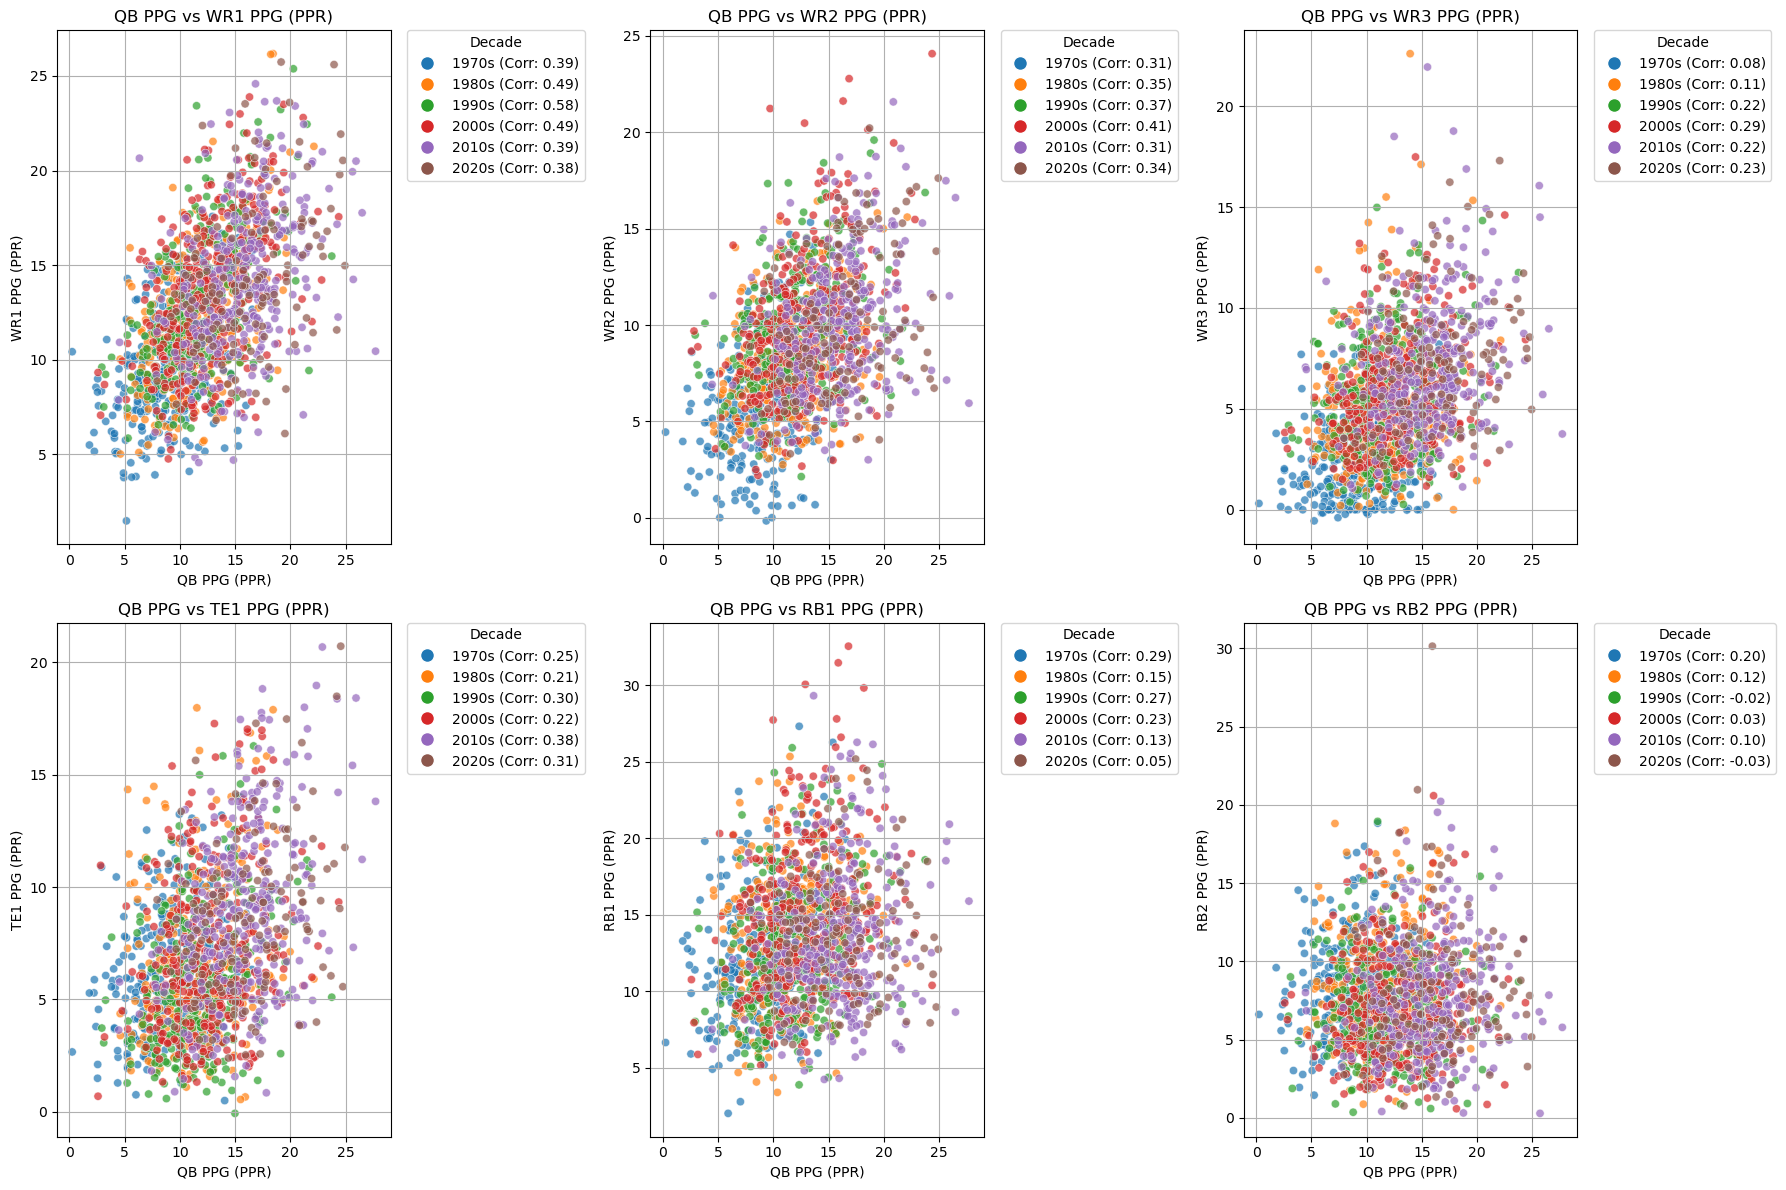

In [113]:
# Filter the data for QB1
qb1_data = df[df['Tm_Pos'] == 'QB1']

# Merge QB1 PPG with the original dataframe based on 'Year' and 'Tm'
merged_ppg_df = df.merge(qb1_data[['Year', 'Tm', 'PPG_ppr']], on=['Year', 'Tm'], suffixes=('', '_QB1'))

# Create a new column for 10-year periods
merged_ppg_df['Decade'] = (merged_ppg_df['Year'] // 10) * 10

# Get unique positions excluding QB1
positions = ['WR1', 'WR2', 'WR3', 'TE1', 'RB1', 'RB2']
positions = [pos for pos in positions if pos != 'QB1']

# Dictionary to hold correlations
decade_correlations = {decade: {} for decade in merged_ppg_df['Decade'].unique()}

# Calculate correlations for each position in each decade
for pos in positions:
    for decade in merged_ppg_df['Decade'].unique():
        pos_data_decade = merged_ppg_df[(merged_ppg_df['Tm_Pos'] == pos) & (merged_ppg_df['Decade'] == decade)]
        correlation = pos_data_decade['PPG_ppr_QB1'].corr(pos_data_decade['PPG_ppr'])
        decade_correlations[decade][pos] = correlation

# Set up the plot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Define colors for different decades
colors = sns.color_palette("tab10", len(merged_ppg_df['Decade'].unique()))

# Iterate over each position and plot
for i, pos in enumerate(positions):
    pos_data = merged_ppg_df[merged_ppg_df['Tm_Pos'] == pos]
    
    # Create a custom legend with correlation values
    legend_labels = []
    for j, decade in enumerate(sorted(merged_ppg_df['Decade'].unique())):
        correlation = decade_correlations[decade][pos]
        label = f"{decade}s (Corr: {correlation:.2f})"
        legend_labels.append((colors[j], label))
    
    # Create the scatter plot
    scatter = sns.scatterplot(
        ax=axes[i],
        x='PPG_ppr_QB1',
        y='PPG_ppr',
        data=pos_data,
        hue='Decade',
        palette=colors,
        alpha=0.7,
        legend=False  # Disable default legend
    )
    
    # Add custom legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color, _ in legend_labels]
    labels = [label for _, label in legend_labels]
    axes[i].legend(handles, labels, title='Decade', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    axes[i].set_title(f'QB PPG vs {pos} PPG (PPR)')
    axes[i].set_xlabel('QB PPG (PPR)')
    axes[i].set_ylabel(f'{pos} PPG (PPR)')
    axes[i].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


- WR1s have the strongest correlation with QBs, consistently hovering around 0.4.
- WR2s have the second strongest correlation with QBs, hovering around 0.35.
- TE1s have the third strongest correlation with QBs, hovering around 0.3.
- WR3s have the weakest correlation with QBs (among pass-catchers), hovering around 0.25
- RBs don't seem to have much of a correlation with QBs. This is especially true since 2020.

## Rushing QBs
How well do other positions perform with elite rushing QBs (think Lamar, Vick), scramblers (Steve Young, Mahomes), and pocket passers (poor mobility)?

In [ ]:
# get rows where a QB had insane rushing season, get all 'Player' names
# get all of these players from the df

# do same for other 2 positions



In [ ]:
# see how RBs do in the 3 groups

In [ ]:
# see how WRs do in the 3 groups

In [ ]:
# see how TEs do in the 3 groups

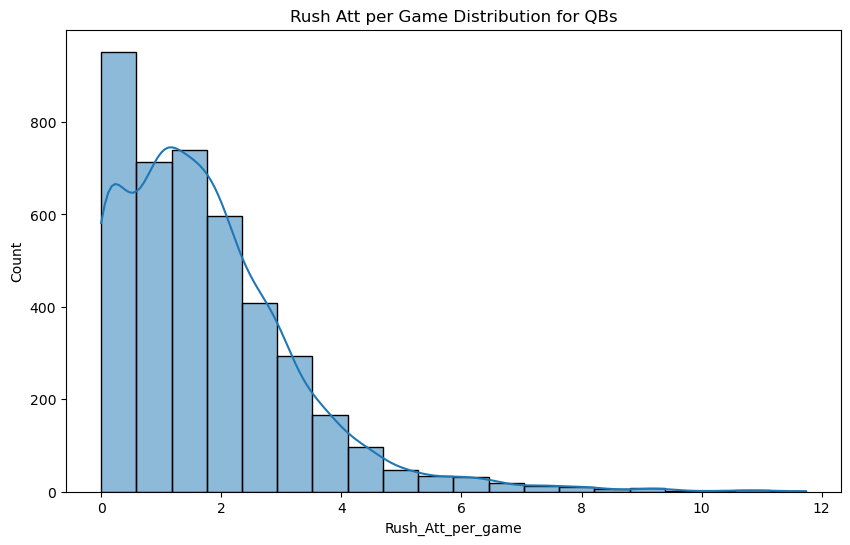

In [4]:
# plot 'Rush_Att_per_game' distribution for QBs
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Pos'] == 'QB']['Rush_Att_per_game'], bins=20, kde=True)
plt.title('Rush Att per Game Distribution for QBs')
plt.show()

In [ ]:
# define a 'rushing' QB
def is_rushing_qb(row):
    if row['Pos'] == 'QB' and row['Rushing_Att'] > 50:
        return 1
    else:
        return 0
    
# apply the function
df['Rushing_QB'] = df.apply(is_rushing_qb, axis=1)

# view
df[df['Rushing_QB'] == 1].head()[['Player', 'Pos', 'Rushing_Att', 'Rushing_Yds', 'Rushing_QB']]

## Takeaways:
1. 
2. 
3.
4.
5.
